# IBM Dynamical Decoupling Optimizations with Superstaq - Strategies

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_dd.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_dd.ipynb)

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit; you can try it out by running `pip install qiskit-superstaq`.

There are many possible ways to determine how and where to place DD sequences within an idling window. We refer to these approaches as strategies. If users want more control over the way Superstaq applies DD, they can specify their desired strategy. Superstaq supports the following dynamical decoupling strategies:

* **Standard**: Places a single DD sequence in each idle window.<br>
* **Syncopated**: Places DD pulses at fixed time intervals, alternating between pulses on neighboring qubits in order to mitigate parasitic ZZ coupling errors.<br>
* **Adaptive** (default): Dynamically spaces DD pulses across idle windows with awareness of neighboring qubits to achieve the parasitic ZZ coupling mitigation of the "syncopated" strategy with fewer pulses and less discretization error.<br>

Users have the ability to specify the dynamical decoupling strategy desired via the keyword argument `dd_strategy`.

All of the above strategies, by default, use the XX sequence: a sequence consisting of a pair of equally-spaced X gates. this can be changed via the `dd_sequence` keyword argument.

In [1]:
# Required Superstaq imports
try:

    import qiskit_superstaq as qss
    import qiskit_ibm_runtime

except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")

    import qiskit_superstaq as qss
    import qiskit_ibm_runtime

import qiskit
import os

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API)).

In [2]:
# Get the qiskit superstaq provider for Superstaq backend
# Provide your api key to the using the "api_key" argument if SUPERSTAQ_API_KEY environment variable is not set.
provider = qss.SuperstaqProvider()

This notebook will target IBM's 127-qubit Brisbane device.

In [3]:
backend = provider.get_backend("ibmq_brisbane_qpu")

## Example 1: Circuit Compilation and DD Optimization with Superstaq

In this example, we will be a pair of 8-qubit GHZ circuits, which we generate below:

In [4]:
n_qubits = 8
circuit = qiskit.QuantumCircuit(8)

circuit.h(0)
for i in range(1, circuit.num_qubits):
    circuit.cx(0, i)

for i in range(0, circuit.num_qubits - 1):
    circuit.cx(-1, i)

circuit.measure_all()

We can draw the circuit using `qiskit`:

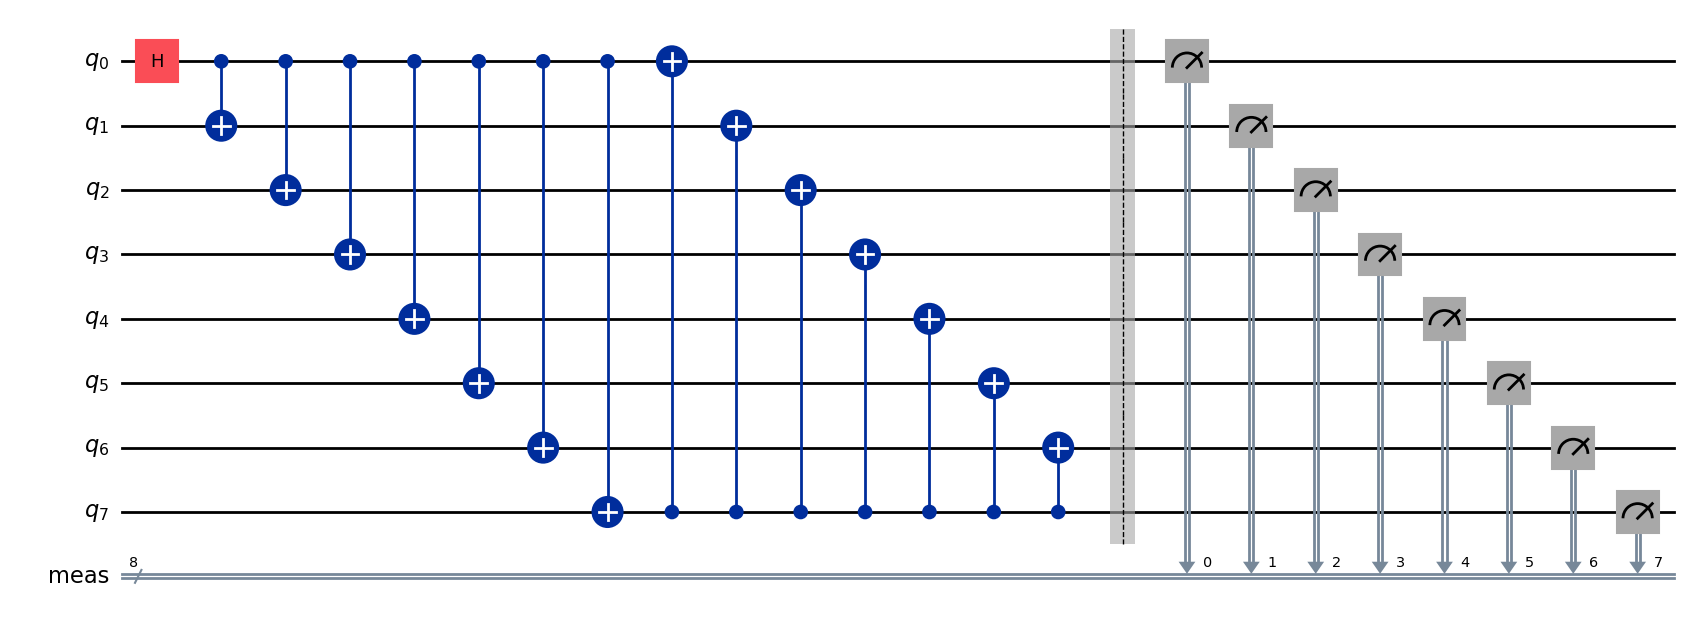

In [5]:
circuit.draw("mpl")

Next, we will compile the logical circuit with Qiskit. Qiskit compilation will serve as a baseline that we use to evaluate Superstaq's error mitigation techniques.

In [6]:
# The local service returns a recent snapshot of the IBM backend, which is sufficient for this transpilation example
ibm_service = qiskit_ibm_runtime.session.QiskitRuntimeLocalService()
ibm_backend = ibm_service.backend("fake_brisbane")

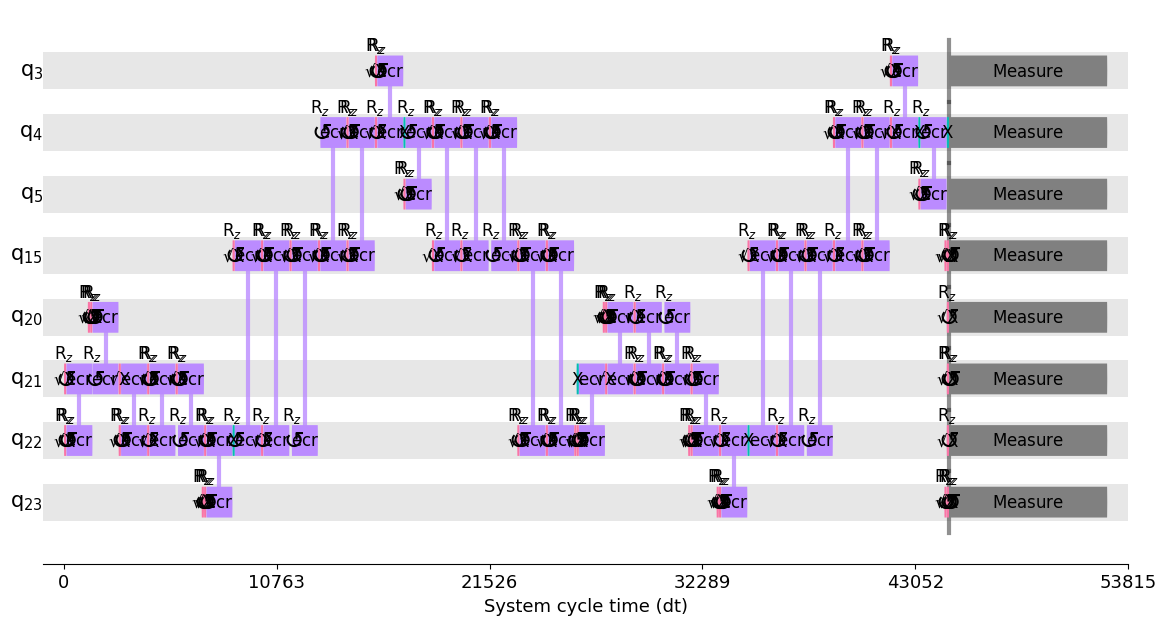

In [7]:
qiskit_optimized = qiskit.transpile(circuit, ibm_backend, optimization_level=3, scheduling_method="alap")

qiskit.visualization.timeline_drawer(qiskit_optimized, show_idle=False)

Superstaq compilation transforms the circuit so that it uses optimized instructions. Here, on qubits with long idling durations we insert XX gates using the basic `static` strategy.

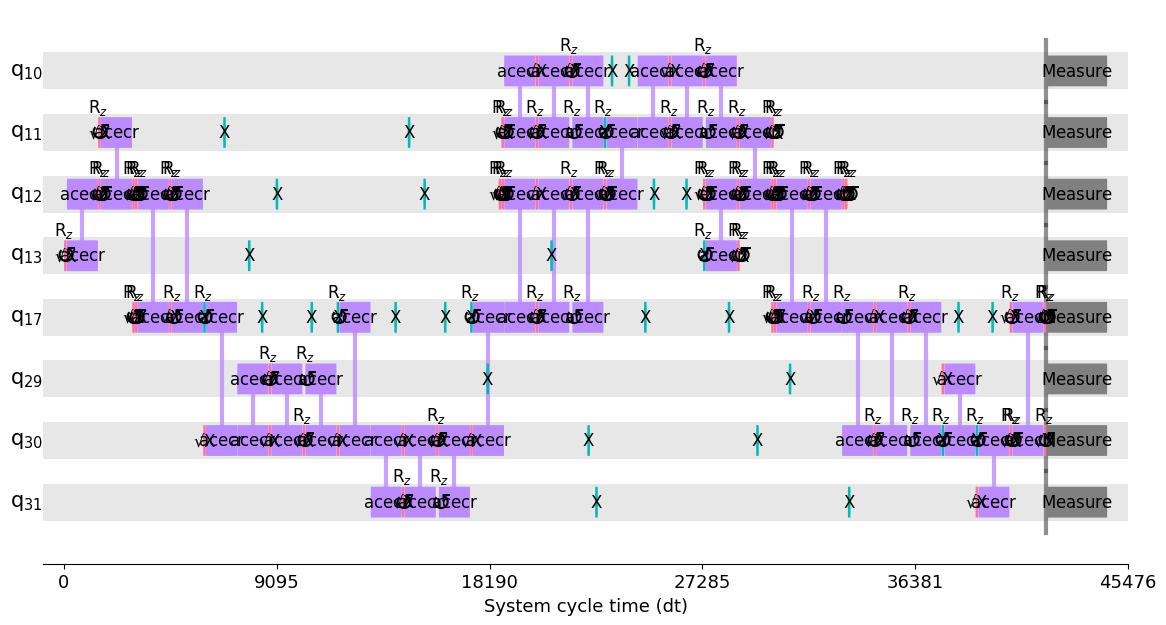

In [8]:
superstaq_optimized = backend.compile(circuit, dd_strategy="standard", dynamical_decoupling=True)

qiskit.visualization.timeline_drawer(superstaq_optimized.pulse_gate_circuit, show_idle=False)

Below, we insert DD using the default "syncopated" strategy.

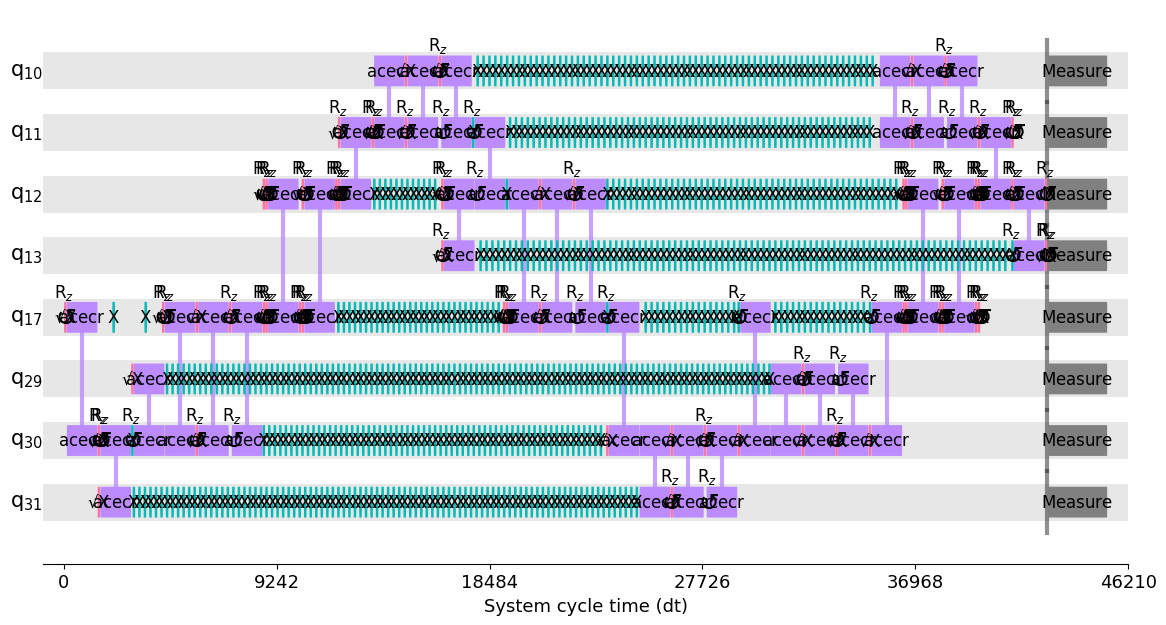

In [9]:
superstaq_optimized = backend.compile(circuit, dd_strategy="syncopated", dynamical_decoupling=True)

qiskit.visualization.timeline_drawer(superstaq_optimized.pulse_gate_circuit, show_idle=False)

And now, we compile with DD using the "adaptive" strategy.

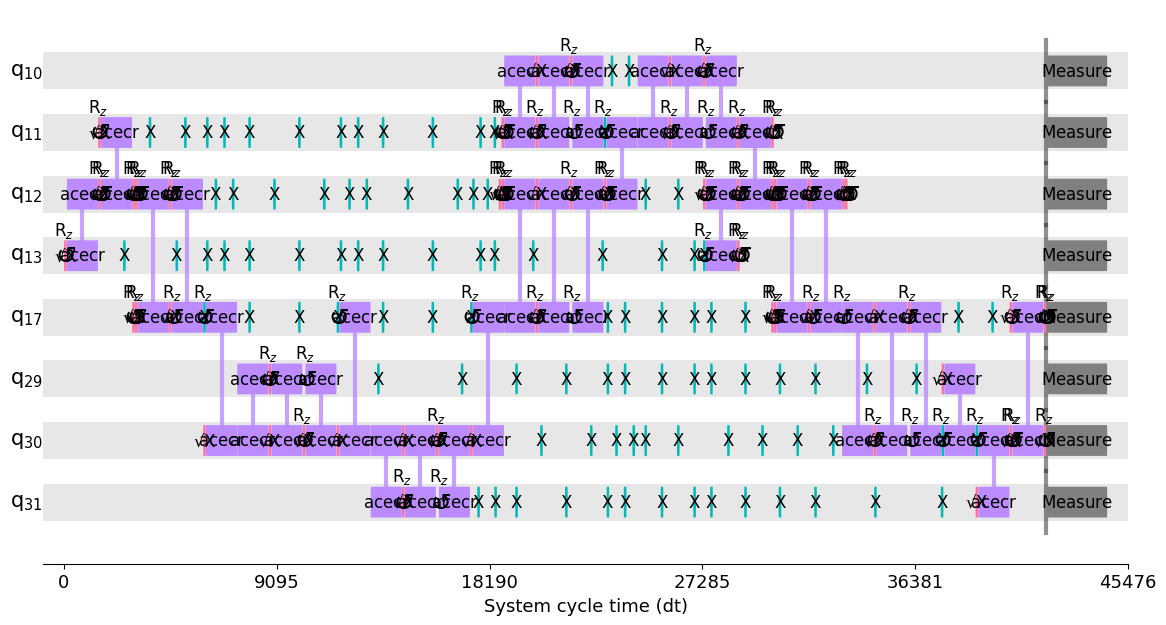

In [10]:
superstaq_optimized = backend.compile(circuit, dd_strategy="adaptive", dynamical_decoupling=True)

qiskit.visualization.timeline_drawer(superstaq_optimized.pulse_gate_circuit, show_idle=False)